In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
sb.set()

from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [2]:
yf.pdr_override()
stocksList = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ASML']
stocksData = {}
for ticker in stocksList:
    df = pdr.get_data_yahoo(ticker, start="2010-01-01", end="2022-03-30")
    df.dropna()
    stocksData[ticker] = df

stocksData

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'AAPL':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2009-12-31    7.611786    7.619643    7.520000    7.526071    6.444381   
 2010-01-04    7.622500    7.660714    7.585000    7.643214    6.544687   
 2010-01-05    7.664286    7.699643    7.616071    7.656429    6.556002   
 2010-01-06    7.656429    7.686786    7.526786    7.534643    6.451720   
 2010-01-07    7.562500    7.571429    7.466071    7.520714    6.439793   
 ...                ...         ...         ...         ...         ...   
 2022-03-23  167.990005  172.639999  167.649994  170.210007  170.210007   
 2022-03-24  171.059998  174.139999  170.210007  174.070007  174.070007   
 2022-03-25  173.880005  175.279999  172.750000  174.720001  174.720001   
 2022-03-28  172.169998  175.729996  172.000000  175.600006  175.600006   
 2022-03-29  176.690002  179.009995  176.339996  178.960007  178.960007   
 
               

In [3]:
name = 'Q-learning agent'

for ticker in stocksList:
    df = stocksData[ticker]

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
for ticker in stocksList:
    print("Ticker:", ticker)
    close = stocksData[ticker]['Adj Close'].values.tolist()
    initial_money = 10000
    window_size = 30
    skip = 1
    batch_size = 1024
    agent = Agent(state_size = window_size, 
                window_size = window_size, 
                trend = close, 
                skip = skip, 
                batch_size = batch_size)
    agent.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

Ticker: AAPL


C:\Users\nobel\AppData\Local\Temp\ipykernel_20276\3505986436.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
N:\Program Files (x86)\Python\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\nobel\AppData\Local\Temp\ipykernel_20276\3505986436.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 103.605931.3, cost: 0.097678, total money: 10103.605931
epoch: 20, total rewards: 123.874667.3, cost: 0.078203, total money: 10123.874667
epoch: 30, total rewards: 166.194341.3, cost: 0.069897, total money: 10166.194341
epoch: 40, total rewards: 146.293475.3, cost: 0.064723, total money: 10146.293475
epoch: 50, total rewards: 163.572459.3, cost: 0.056686, total money: 10163.572459
epoch: 60, total rewards: 195.690841.3, cost: 0.053941, total money: 10195.690841
epoch: 70, total rewards: 190.223853.3, cost: 0.051369, total money: 10190.223853
epoch: 80, total rewards: 203.370146.3, cost: 0.046886, total money: 10203.370146
epoch: 90, total rewards: 193.508457.3, cost: 0.042211, total money: 10193.508457
epoch: 100, total rewards: 195.778279.3, cost: 0.044341, total money: 10195.778279
epoch: 110, total rewards: 175.014787.3, cost: 0.043288, total money: 10175.014787
epoch: 120, total rewards: 175.542163.3, cost: 0.038098, total money: 10175.542163
epoch: 130, t

N:\Program Files (x86)\Python\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 149.657179.3, cost: 0.266720, total money: 10149.657179
epoch: 20, total rewards: 201.697443.3, cost: 0.165376, total money: 10201.697443
epoch: 30, total rewards: 217.723791.3, cost: 0.126958, total money: 10217.723791
epoch: 40, total rewards: 328.861629.3, cost: 0.129240, total money: 10328.861629
epoch: 50, total rewards: 140.044996.3, cost: 0.108148, total money: 10140.044996
epoch: 60, total rewards: 95.831553.3, cost: 0.089038, total money: 10095.831553
epoch: 70, total rewards: 78.276426.3, cost: 0.096226, total money: 10078.276426
epoch: 80, total rewards: 45.067471.3, cost: 0.078499, total money: 10045.067471
epoch: 90, total rewards: 84.113592.3, cost: 0.069593, total money: 10084.113592
epoch: 100, total rewards: 48.399963.3, cost: 0.070057, total money: 10048.399963
epoch: 110, total rewards: 84.053738.3, cost: 0.059976, total money: 10084.053738
epoch: 120, total rewards: 13.856302.3, cost: 0.066180, total money: 10013.856302
epoch: 130, total re

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 23.703512, total balance 9976.296488
day 6, sell 1 unit at price 23.200388, investment -2.122573 %, total balance 9999.496876,
day 14: buy 1 unit at price 22.484674, total balance 9977.012201
day 15, sell 1 unit at price 22.888594, investment 1.796420 %, total balance 9999.900795,
day 19: buy 1 unit at price 22.144539, total balance 9977.756256
day 20: buy 1 unit at price 22.647663, total balance 9955.108593
day 21: buy 1 unit at price 23.037401, total balance 9932.071192
day 23: buy 1 unit at price 21.988640, total balance 9910.082552
day 25: buy 1 unit at price 21.669760, total balance 9888.412792
day 26: buy 1 unit at price 22.300430, total balance 9866.112362
day 27, sell 1 unit at price 22.314604, investment 0.767977 %, total balance 9888.426966,
day 29, sell 1 unit at price 22.286263, investment -1.595752 %, total balance 9910.713228,
day 30: buy 1 unit at price 22.782303, total balance 9887.930925
day 32: buy 1 unit at price 22.739784, total balance 98

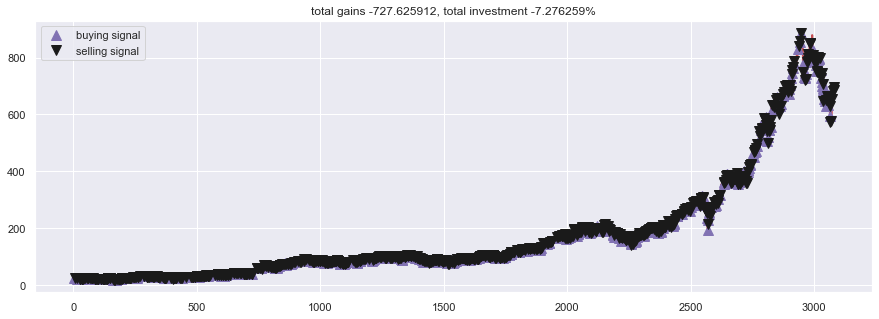

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()